In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import seaborn as sns
import json
import powerlaw

In [3]:
import scipy
print(scipy.__version__)

1.10.1


In [4]:
%matplotlib inline

In [5]:
oa_to_parish_lookup = pd.read_csv('../data/OAs_(2021)_to_Civil_Parish_and_Non-Civil_Parished_Areas_to_LTLA_to_UTLA_to_Region_to_Country_(May_2022)_Lookup_in_England_and_Wales.csv')
oa_to_parish_lookup.head()

/var/folders/zs/1hvc18dn7v94z77k1xy7g90c0000gn/T/ipykernel_92944/1533396775.py:1: DtypeWarning: Columns (4,7,10,13) have mixed types. Specify dtype option on import or set low_memory=False.
  oa_to_parish_lookup = pd.read_csv('data/OAs_(2021)_to_Civil_Parish_and_Non-Civil_Parished_Areas_to_LTLA_to_UTLA_to_Region_to_Country_(May_2022)_Lookup_in_England_and_Wales.csv')


,ObjectId,OA21CD,PAR22CD,PAR22NM,PAR22NMW,LTLA22CD,LTLA22NM,LTLA22NMW,UTLA22CD,UTLA22NM,UTLA22NMW,RGN22CD,RGN22NM,RGN22NMW,CTRY22CD,CTRY22NM,CTRY22NMW,NAT22CD,NAT22NM,NAT22NMW
0,1,E00060311,E04000255,Dalton Piercy,NaN,E06000001,Hartlepool,NaN,E06000001,Hartlepool,NaN,E12000001,North East,NaN,E92000001,England,Lloegr,K04000001,England and Wales,Cymru a Lloegr
1,2,E00060356,E04000257,Greatham,NaN,E06000001,Hartlepool,NaN,E06000001,Hartlepool,NaN,E12000001,North East,NaN,E92000001,England,Lloegr,K04000001,England and Wales,Cymru a Lloegr
2,3,E00060360,E04000257,Greatham,NaN,E06000001,Hartlepool,NaN,E06000001,Hartlepool,NaN,E12000001,North East,NaN,E92000001,England,Lloegr,K04000001,England and Wales,Cymru a Lloegr
3,4,E00060357,E04000257,Greatham,NaN,E06000001,Hartlepool,NaN,E06000001,Hartlepool,NaN,E12000001,North East,NaN,E92000001,England,Lloegr,K04000001,England and Wales,Cymru a Lloegr
4,5,E00060359,E04000257,Greatham,NaN,E06000001,Hartlepool,NaN,E06000001,Hartlepool,NaN,E12000001,North East,NaN,E92000001,England,Lloegr,K04000001,England and Wales,Cymru a Lloegr


In [6]:
oa_to_parish_lookup = oa_to_parish_lookup[[
    'OA21CD',
    'PAR22CD',
    'PAR22NM',
    'RGN22NM'
]]

oa_to_parish_lookup.head()

,OA21CD,PAR22CD,PAR22NM,RGN22NM
0,E00060311,E04000255,Dalton Piercy,North East
1,E00060356,E04000257,Greatham,North East
2,E00060360,E04000257,Greatham,North East
3,E00060357,E04000257,Greatham,North East
4,E00060359,E04000257,Greatham,North East


In [7]:
oa_populations = pd.read_csv('../data/census2021-ts001-oa.csv')
oa_populations.head()

,date,geography,geography code,Residence type: Total; measures: Value,Residence type: Lives in a household; measures: Value,Residence type: Lives in a communal establishment; measures: Value
0,2021,E00060274,E00060274,273,273,0
1,2021,E00060275,E00060275,416,416,0
2,2021,E00060276,E00060276,259,259,0
3,2021,E00060277,E00060277,278,278,0
4,2021,E00060279,E00060279,276,276,0


In [8]:
oa_total_frame = oa_to_parish_lookup.merge(
    oa_populations[['geography code', 'Residence type: Total; measures: Value']], 
    how='inner', 
    left_on='OA21CD', 
    right_on='geography code')

oa_total_frame.head()
                    

,OA21CD,PAR22CD,PAR22NM,RGN22NM,geography code,Residence type: Total; measures: Value
0,E00060311,E04000255,Dalton Piercy,North East,E00060311,312
1,E00060356,E04000257,Greatham,North East,E00060356,283
2,E00060360,E04000257,Greatham,North East,E00060360,274
3,E00060357,E04000257,Greatham,North East,E00060357,298
4,E00060359,E04000257,Greatham,North East,E00060359,274


In [9]:
oa_total_frame = oa_total_frame.rename(columns={'Residence type: Total; measures: Value': 'population'}, errors='raise')
oa_total_frame = oa_total_frame[[
    'OA21CD',
    'PAR22CD',
    'PAR22NM',
    'RGN22NM',
    'population'
]]

oa_total_frame.head()

,OA21CD,PAR22CD,PAR22NM,RGN22NM,population
0,E00060311,E04000255,Dalton Piercy,North East,312
1,E00060356,E04000257,Greatham,North East,283
2,E00060360,E04000257,Greatham,North East,274
3,E00060357,E04000257,Greatham,North East,298
4,E00060359,E04000257,Greatham,North East,274


In [10]:
size_frame = pd.read_csv('../geo_data/Output_Areas_Dec_2021_Boundaries_Full_Clipped_EW_BFC_2022_-340120420164038365.csv')
size_frame.head()

,OBJECTID,OA21CD,Shape__Area,Shape__Length,GlobalID
0,1,E00000001,6707.003326,448.104925,b6c81a78-d070-4324-a2e9-3522777aca9c
1,2,E00000003,4186.970726,341.814871,9be984cf-6bdf-470b-bd01-16793c7135f5
2,3,E00000005,8736.115654,444.386357,6460aa1d-b8b7-4062-a679-354a99d33f73
3,4,E00000007,73494.158020,1607.023365,de2b0475-c5b9-4aec-8804-43e3e21d54e2
4,5,E00000010,2533.057602,259.046872,55b296f3-e208-41a6-a806-1a020ed907a5


In [11]:
oa_total_frame = oa_total_frame.merge(
    size_frame[['OA21CD', 'Shape__Area']],
    how='inner',
    on='OA21CD'
)
oa_total_frame = oa_total_frame.rename(
    columns={'Shape__Area': 'area'}, 
    errors='raise'
)

In [12]:
oa_total_frame.head()

,OA21CD,PAR22CD,PAR22NM,RGN22NM,population,area
0,E00060311,E04000255,Dalton Piercy,North East,312,6.758443e+06
1,E00060356,E04000257,Greatham,North East,283,5.098650e+05
2,E00060360,E04000257,Greatham,North East,274,6.863565e+04
3,E00060357,E04000257,Greatham,North East,298,3.589880e+05
4,E00060359,E04000257,Greatham,North East,274,6.126857e+04


In [13]:
import glob
to_include = list(set(glob.glob('../output_data/all_data_final_updated_*.json')) - set(glob.glob('output_data/all_data_final_updated_errors*.json')))
region_frames = [pd.read_json(i) for i in to_include]
big_df = pd.concat(region_frames)
big_df.shape


(178605, 3)

In [14]:
oa_total_frame = oa_total_frame.merge(
    big_df[['OA21CD', 'amenities']],
    how='left',
    on='OA21CD'
)
oa_total_frame.head()

,OA21CD,PAR22CD,PAR22NM,RGN22NM,population,area,amenities
0,E00060311,E04000255,Dalton Piercy,North East,312,6.758443e+06,"[{'name': 'N/A', 'amenity': 'post_box', 'data_..."
1,E00060356,E04000257,Greatham,North East,283,5.098650e+05,"[{'name': 'The Bull and Dog', 'amenity': 'pub'..."
2,E00060360,E04000257,Greatham,North East,274,6.863565e+04,[]
3,E00060357,E04000257,Greatham,North East,298,3.589880e+05,"[{'name': 'N/A', 'amenity': 'waste_basket', 'd..."
4,E00060359,E04000257,Greatham,North East,274,6.126857e+04,[]


In [15]:
oa_total_frame.tail()

,OA21CD,PAR22CD,PAR22NM,RGN22NM,population,area,amenities
188875,W00006941,W04000881,Vaynor,Wales,274,5.605059e+05,NaN
188876,W00006932,W04000881,Vaynor,Wales,303,8.202506e+04,NaN
188877,W00006935,W04000881,Vaynor,Wales,211,6.634248e+04,NaN
188878,W00006940,W04000881,Vaynor,Wales,422,2.768095e+05,NaN
188879,W00006934,W04000881,Vaynor,Wales,293,3.034093e+06,NaN


In [16]:
## drop Wales
drop_wales = oa_total_frame[oa_total_frame.RGN22NM != 'Wales']
drop_wales.shape

(178605, 7)

In [17]:
drop_wales[pd.isnull(drop_wales.amenities)].groupby(['RGN22NM']).size()

Series([], dtype: int64)

In [18]:
oa_to_parish_lookup.groupby(['RGN22NM']).size()

RGN22NM
East Midlands               15393
East of England             19972
London                      26369
North East                   9100
North West                  24050
South East                  28969
South West                  18427
Wales                       10275
West Midlands               18584
Yorkshire and The Humber    17741
dtype: int64

In [19]:
parish_frame = drop_wales[['PAR22CD', 'PAR22NM', 'RGN22NM', 'population', 'area']].groupby(['PAR22CD', 'PAR22NM', 'RGN22NM']).agg('sum').reset_index()
parish_frame.head()

,PAR22CD,PAR22NM,RGN22NM,population,area
0,E04000001,Blackrod,North West,5517,8.599134e+06
1,E04000002,Horwich,North West,20908,1.424275e+07
2,E04000003,Westhoughton,North West,25340,1.786415e+07
3,E04000005,Saddleworth,North West,25466,7.613353e+07
4,E04000008,Mossley,North West,11566,8.658747e+06


## Adding on Rural/Urban classification

In [20]:
rural_urban_lookup = pd.read_csv('../data/RUC11_OA11_EW.csv')
rural_urban_lookup.head()

,OA11CD,RUC11CD,RUC11,BOUND_CHGIND,ASSIGN_CHGIND,ASSIGN_CHREASON
0,E00000001,A1,Urban major conurbation,U,NaN,NaN
1,E00000003,A1,Urban major conurbation,U,NaN,NaN
2,E00000005,A1,Urban major conurbation,U,NaN,NaN
3,E00000007,A1,Urban major conurbation,U,NaN,NaN
4,E00000010,A1,Urban major conurbation,U,NaN,NaN


In [21]:
oa11_oa21_lookup = pd.read_csv('../data/OA_(2011)_to_OA_(2021)_to_Local_Authority_District_(2022)_for_England_and_Wales_Lookup_(Version_2).csv')
oa11_oa21_lookup.head()

/var/folders/zs/1hvc18dn7v94z77k1xy7g90c0000gn/T/ipykernel_92944/1732757884.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  oa11_oa21_lookup = pd.read_csv('data/OA_(2011)_to_OA_(2021)_to_Local_Authority_District_(2022)_for_England_and_Wales_Lookup_(Version_2).csv')


,ObjectId,OA11CD,OA21CD,CHNGIND,LAD22CD,LAD22NM,LAD22NMW
0,1,E00000124,E00000124,U,E09000002,Barking and Dagenham,NaN
1,2,E00000125,E00000125,U,E09000002,Barking and Dagenham,NaN
2,3,E00000128,E00000128,U,E09000002,Barking and Dagenham,NaN
3,4,E00000129,E00000129,U,E09000002,Barking and Dagenham,NaN
4,5,E00000130,E00000130,U,E09000002,Barking and Dagenham,NaN


In [22]:
rural_urban_lookup = rural_urban_lookup[['OA11CD', 'RUC11CD', 'RUC11']].merge(
    oa11_oa21_lookup[['OA11CD', 'OA21CD']],
    how='left',
    on='OA11CD'
)
rural_urban_lookup.head()

,OA11CD,RUC11CD,RUC11,OA21CD
0,E00000001,A1,Urban major conurbation,E00000001
1,E00000003,A1,Urban major conurbation,E00000003
2,E00000005,A1,Urban major conurbation,E00000005
3,E00000007,A1,Urban major conurbation,E00000007
4,E00000010,A1,Urban major conurbation,E00000010


In [23]:
with_rural = drop_wales.merge(
    rural_urban_lookup[[
        'OA21CD',
        'RUC11CD',
        'RUC11'
    ]],
    how='left',
    on='OA21CD'
)

with_rural.head()

,OA21CD,PAR22CD,PAR22NM,RGN22NM,population,area,amenities,RUC11CD,RUC11
0,E00060311,E04000255,Dalton Piercy,North East,312,6.758443e+06,"[{'name': 'N/A', 'amenity': 'post_box', 'data_...",E1,Rural village
1,E00060356,E04000257,Greatham,North East,283,5.098650e+05,"[{'name': 'The Bull and Dog', 'amenity': 'pub'...",C1,Urban city and town
2,E00060360,E04000257,Greatham,North East,274,6.863565e+04,[],C1,Urban city and town
3,E00060357,E04000257,Greatham,North East,298,3.589880e+05,"[{'name': 'N/A', 'amenity': 'waste_basket', 'd...",D1,Rural town and fringe
4,E00060359,E04000257,Greatham,North East,274,6.126857e+04,[],C1,Urban city and town


In [24]:
with_rural.groupby(['RUC11'])[[ 'area']].describe()

area                \
                                                      count          mean   
RUC11                                                                       
Rural hamlets and isolated dwellings                 6055.0  8.612901e+06   
Rural hamlets and isolated dwellings in a spars...    533.0  2.408017e+07   
Rural town and fringe                               15455.0  4.986474e+05   
Rural town and fringe in a sparse setting             677.0  6.755757e+05   
Rural village                                        9442.0  3.594200e+06   
Rural village in a sparse setting                     560.0  7.883246e+06   
Urban city and town                                 77942.0  1.801583e+05   
Urban city and town in a sparse setting               309.0  3.200873e+05   
Urban major conurbation                             61842.0  8.642908e+04   
Urban minor conurbation                              6459.0  1.320435e+05   

                                                                  \
                                                             std   
RUC11                                                              
Rural hamlets and isolated dwellings                8.013448e+06   
Rural hamlets and isolated dwellings in a spars...  2.278767e+07   
Rural town and fringe                               1.271245e+06   
Rural town and fringe in a sparse setting           2.114947e+06   
Rural village                                       4.197805e+06   
Rural village in a sparse setting                   1.212237e+07   
Urban city and town                                 6.126136e+05   
Urban city and town in a sparse setting             1.003697e+06   
Urban major conurbation                             2.138449e+05   
Urban minor conurbation                             2.974184e+05   

                                                                   \
                                                              min   
RUC11                                                               
Rural hamlets and isolated dwellings                  8041.212532   
Rural hamlets and isolated dwellings in a spars...  120146.604691   
Rural town and fringe                                 8176.085709   
Rural town and fringe in a sparse setting            15904.477230   
Rural village                                        12769.463512   
Rural village in a sparse setting                    38411.565811   
Urban city and town                                    290.793518   
Urban city and town in a sparse setting              14198.348251   
Urban major conurbation                                201.248619   
Urban minor conurbation                                  0.039673   

                                                                  \
                                                             25%   
RUC11                                                              
Rural hamlets and isolated dwellings                3.852323e+06   
Rural hamlets and isolated dwellings in a spars...  1.110002e+07   
Rural town and fringe                               6.771172e+04   
Rural town and fringe in a sparse setting           7.333769e+04   
Rural village                                       6.080874e+05   
Rural village in a sparse setting                   1.003910e+06   
Urban city and town                                 4.338182e+04   
Urban city and town in a sparse setting             5.480465e+04   
Urban major conurbation                             2.843624e+04   
Urban minor conurbation                             4.245505e+04   

                                                                  \
                                                             50%   
RUC11                                                              
Rural hamlets and isolated dwellings                7.152737e+06   
Rural hamlets and isolated dwellings in a spars...  1.700971e+07   
Rural town and fringe                        

In [25]:
with_rural[['RUC11', 'RUC11CD']].drop_duplicates()

,RUC11,RUC11CD
0,Rural village,E1
1,Urban city and town,C1
3,Rural town and fringe,D1
6,Rural hamlets and isolated dwellings,F1
10042,Urban minor conurbation,B1
10978,Rural hamlets and isolated dwellings in a spar...,F2
11072,Rural village in a sparse setting,E2
11360,Urban city and town in a sparse setting,C2
11413,Rural town and fringe in a sparse setting,D2
20708,Urban major conurbation,A1


In [26]:
official_rural_list = [
    'D1', 'E1', 'F1', 'D2', 'E2', 'F2'
]

with_rural.head()

,OA21CD,PAR22CD,PAR22NM,RGN22NM,population,area,amenities,RUC11CD,RUC11
0,E00060311,E04000255,Dalton Piercy,North East,312,6.758443e+06,"[{'name': 'N/A', 'amenity': 'post_box', 'data_...",E1,Rural village
1,E00060356,E04000257,Greatham,North East,283,5.098650e+05,"[{'name': 'The Bull and Dog', 'amenity': 'pub'...",C1,Urban city and town
2,E00060360,E04000257,Greatham,North East,274,6.863565e+04,[],C1,Urban city and town
3,E00060357,E04000257,Greatham,North East,298,3.589880e+05,"[{'name': 'N/A', 'amenity': 'waste_basket', 'd...",D1,Rural town and fringe
4,E00060359,E04000257,Greatham,North East,274,6.126857e+04,[],C1,Urban city and town


In [27]:
with_rural['is_rural'] = with_rural.RUC11CD.isin(official_rural_list)
with_rural.head()

,OA21CD,PAR22CD,PAR22NM,RGN22NM,population,area,amenities,RUC11CD,RUC11,is_rural
0,E00060311,E04000255,Dalton Piercy,North East,312,6.758443e+06,"[{'name': 'N/A', 'amenity': 'post_box', 'data_...",E1,Rural village,True
1,E00060356,E04000257,Greatham,North East,283,5.098650e+05,"[{'name': 'The Bull and Dog', 'amenity': 'pub'...",C1,Urban city and town,False
2,E00060360,E04000257,Greatham,North East,274,6.863565e+04,[],C1,Urban city and town,False
3,E00060357,E04000257,Greatham,North East,298,3.589880e+05,"[{'name': 'N/A', 'amenity': 'waste_basket', 'd...",D1,Rural town and fringe,True
4,E00060359,E04000257,Greatham,North East,274,6.126857e+04,[],C1,Urban city and town,False


In [28]:
with_rural.groupby(['is_rural']).describe()

population                                                     \
              count        mean         std   min    25%    50%    75%   
is_rural                                                                 
False      146552.0  318.812435   98.411545  98.0  266.0  308.0  358.0   
True        32722.0  309.130463  104.301149  98.0  253.0  300.0  353.0   

                      area                                           \
             max     count          mean           std          min   
is_rural                                                              
False     4502.0  146552.0  1.387809e+05  4.764933e+05     0.039673   
True      3327.0   32722.0  3.407520e+06  6.727087e+06  8041.212532   

                                                                    
                    25%            50%           75%           max  
is_rural                                                            
False      36838.736525   56246.968002  9.618878e+04  4.729333e+07  
True      115628.284220  627994.315384  4.527755e+06  2.016620e+08

In [29]:
agg_stats = with_rural.groupby(['is_rural']).sum().reset_index()
agg_stats

,is_rural,population,area
0,False,46722600,2.033862e+10
1,True,10115367,1.115009e+11


In [30]:
agg_stats['pct_population'] = 100*agg_stats.population/agg_stats.population.sum()
agg_stats['pct_area'] = 100*agg_stats.area/agg_stats.area.sum()
agg_stats

,is_rural,population,area,pct_population,pct_area
0,False,46722600,2.033862e+10,82.203151,15.426807
1,True,10115367,1.115009e+11,17.796849,84.573193


## Facilities by urban/rural

In [31]:
import collections

def extract_amenity_list(value):
    return collections.Counter([entry['amenity'] for entry in value])

In [32]:
with_rural['amenity_list'] = with_rural.amenities.apply(extract_amenity_list)
with_rural.head()

,OA21CD,PAR22CD,PAR22NM,RGN22NM,population,area,amenities,RUC11CD,RUC11,is_rural,amenity_list
0,E00060311,E04000255,Dalton Piercy,North East,312,6.758443e+06,"[{'name': 'N/A', 'amenity': 'post_box', 'data_...",E1,Rural village,True,"{'post_box': 1, 'telephone': 1, 'parking': 2, ..."
1,E00060356,E04000257,Greatham,North East,283,5.098650e+05,"[{'name': 'The Bull and Dog', 'amenity': 'pub'...",C1,Urban city and town,False,"{'pub': 3, 'place_of_worship': 1, 'post_box': 1}"
2,E00060360,E04000257,Greatham,North East,274,6.863565e+04,[],C1,Urban city and town,False,{}
3,E00060357,E04000257,Greatham,North East,298,3.589880e+05,"[{'name': 'N/A', 'amenity': 'waste_basket', 'd...",D1,Rural town and fringe,True,"{'waste_basket': 1, 'parking': 2}"
4,E00060359,E04000257,Greatham,North East,274,6.126857e+04,[],C1,Urban city and town,False,{}


In [33]:
amenity_counters = with_rural.groupby(['is_rural']).amenity_list.sum(collections.Counter()).reset_index()
amenity_counters

,is_rural,amenity_list
0,False,"{'pub': 22922, 'place_of_worship': 19186, 'pos..."
1,True,"{'post_box': 26940, 'telephone': 4540, 'parkin..."


In [34]:
rural_counter = amenity_counters[amenity_counters.is_rural].amenity_list.values[0]
urban_counter = amenity_counters[~amenity_counters.is_rural].amenity_list.values[0]

In [35]:
urban_counter.most_common(10)

[('parking', 123288),
 ('parking_space', 67989),
 ('bench', 61504),
 ('bicycle_parking', 46391),
 ('post_box', 45004),
 ('waste_basket', 35454),
 ('fast_food', 30369),
 ('restaurant', 24997),
 ('pub', 22922),
 ('cafe', 22673)]

In [36]:
rural_counter.most_common(10)

[('parking', 52442),
 ('bench', 29427),
 ('post_box', 26940),
 ('place_of_worship', 13333),
 ('pub', 11706),
 ('parking_space', 10757),
 ('grave_yard', 8665),
 ('waste_basket', 7959),
 ('school', 6532),
 ('cafe', 5949)]

In [37]:
with_rural.groupby('is_rural').size()

is_rural
False    146552
True      32722
dtype: int64

In [38]:
normalised_rural = collections.Counter()
total_rural = sum(rural_counter.values())
for item, count in rural_counter.items():
    normalised_rural[item] = 100*count/total_rural
    
normalised_urban = collections.Counter()
total_urban = sum(urban_counter.values())
for item, count in urban_counter.items():
    normalised_urban[item] = 100*count/total_urban

In [39]:
normalised_urban.most_common(10)

[('parking', 18.660971463946613),
 ('parking_space', 10.290870067340425),
 ('bench', 9.309295218663394),
 ('bicycle_parking', 7.02177930685831),
 ('post_box', 6.811841864280817),
 ('waste_basket', 5.366346134926053),
 ('fast_food', 4.5966764193481495),
 ('restaurant', 3.783566151484925),
 ('pub', 3.4694924720701468),
 ('cafe', 3.431803630540373)]

In [40]:
normalised_rural.most_common(10)

[('parking', 22.537862508810232),
 ('bench', 12.64676557047326),
 ('post_box', 11.577934022107236),
 ('place_of_worship', 5.730088875900362),
 ('pub', 5.030857300029224),
 ('parking_space', 4.623008028055216),
 ('grave_yard', 3.723934606590913),
 ('waste_basket', 3.4205188152172044),
 ('school', 2.807240721321621),
 ('cafe', 2.5566863213628785)]

In [41]:
rural_population=with_rural[with_rural.is_rural].population.sum()
rural_oas = with_rural[with_rural.is_rural].shape[0]
urban_population=with_rural[~with_rural.is_rural].population.sum()
urban_oas = with_rural[~with_rural.is_rural].shape[0]

rural_frame = pd.DataFrame(rural_counter.items(), columns=['amenity', 'number'])
rural_frame['pct_items'] = 100*rural_frame.number / rural_frame.number.sum()
rural_frame['num_per_person'] = rural_frame.number / rural_population
rural_frame['num_per_oa'] = rural_frame.number / rural_oas
urban_frame = pd.DataFrame(urban_counter.items(), columns=['amenity', 'number'])
urban_frame['pct_items'] = 100*urban_frame.number / urban_frame.number.sum()
urban_frame['num_per_person'] = urban_frame.number / urban_population
urban_frame['num_per_oa'] = urban_frame.number / urban_oas
urban_frame.head()

,amenity,number,pct_items,num_per_person,num_per_oa
0,pub,22922,3.469492,0.000491,0.156409
1,place_of_worship,19186,2.904008,0.000411,0.130916
2,post_box,45004,6.811842,0.000963,0.307086
3,toilets,5262,0.796461,0.000113,0.035905
4,bench,61504,9.309295,0.001316,0.419674


In [42]:
mergey = urban_frame.merge(rural_frame, how='left', on='amenity', suffixes=('_urban', '_rural'))
mergey.head()

,amenity,number_urban,pct_items_urban,num_per_person_urban,num_per_oa_urban,number_rural,pct_items_rural,num_per_person_rural,num_per_oa_rural
0,pub,22922,3.469492,0.000491,0.156409,11706.0,5.030857,0.001157,0.357741
1,place_of_worship,19186,2.904008,0.000411,0.130916,13333.0,5.730089,0.001318,0.407463
2,post_box,45004,6.811842,0.000963,0.307086,26940.0,11.577934,0.002663,0.823299
3,toilets,5262,0.796461,0.000113,0.035905,3749.0,1.611198,0.000371,0.114571
4,bench,61504,9.309295,0.001316,0.419674,29427.0,12.646766,0.002909,0.899303


In [43]:
mergey['pct_diff'] = mergey.pct_items_urban - mergey.pct_items_rural
mergey['diff_per_person'] = mergey.num_per_person_urban - mergey.num_per_person_rural
mergey['diff_per_oa'] = mergey.num_per_oa_urban - mergey.num_per_oa_rural
mergey.head()

,amenity,number_urban,pct_items_urban,num_per_person_urban,num_per_oa_urban,number_rural,pct_items_rural,num_per_person_rural,num_per_oa_rural,pct_diff,diff_per_person,diff_per_oa
0,pub,22922,3.469492,0.000491,0.156409,11706.0,5.030857,0.001157,0.357741,-1.561365,-0.000667,-0.201332
1,place_of_worship,19186,2.904008,0.000411,0.130916,13333.0,5.730089,0.001318,0.407463,-2.826080,-0.000907,-0.276547
2,post_box,45004,6.811842,0.000963,0.307086,26940.0,11.577934,0.002663,0.823299,-4.766092,-0.001700,-0.516214
3,toilets,5262,0.796461,0.000113,0.035905,3749.0,1.611198,0.000371,0.114571,-0.814737,-0.000258,-0.078666
4,bench,61504,9.309295,0.001316,0.419674,29427.0,12.646766,0.002909,0.899303,-3.337470,-0.001593,-0.479630


In [44]:
mergey.sort_values(by='pct_diff').head(10)

,amenity,number_urban,pct_items_urban,num_per_person_urban,num_per_oa_urban,number_rural,pct_items_rural,num_per_person_rural,num_per_oa_rural,pct_diff,diff_per_person,diff_per_oa
2,post_box,45004,6.811842,0.000963,0.307086,26940.0,11.577934,0.002663,0.823299,-4.766092,-0.001700,-0.516214
11,parking,123288,18.660971,0.002639,0.841258,52442.0,22.537863,0.005184,1.602653,-3.876891,-0.002546,-0.761395
14,grave_yard,2409,0.364628,0.000052,0.016438,8665.0,3.723935,0.000857,0.264807,-3.359306,-0.000805,-0.248369
4,bench,61504,9.309295,0.001316,0.419674,29427.0,12.646766,0.002909,0.899303,-3.337470,-0.001593,-0.479630
1,place_of_worship,19186,2.904008,0.000411,0.130916,13333.0,5.730089,0.001318,0.407463,-2.826080,-0.000907,-0.276547
73,hunting_stand,60,0.009082,0.000001,0.000409,5386.0,2.314727,0.000532,0.164599,-2.305646,-0.000531,-0.164189
0,pub,22922,3.469492,0.000491,0.156409,11706.0,5.030857,0.001157,0.357741,-1.561365,-0.000667,-0.201332
35,community_centre,5418,0.820073,0.000116,0.036970,4360.0,1.873786,0.000431,0.133244,-1.053713,-0.000315,-0.096274
3,toilets,5262,0.796461,0.000113,0.035905,3749.0,1.611198,0.000371,0.114571,-0.814737,-0.000258,-0.078666
9,post_office,4630,0.700801,0.000099,0.031593,2889.0,1.241598,0.000286,0.088289,-0.540797,-0.000187,-0.056696


In [45]:
mergey.sort_values(by='pct_diff', ascending=False).head(10)

,amenity,number_urban,pct_items_urban,num_per_person_urban,num_per_oa_urban,number_rural,pct_items_rural,num_per_person_rural,num_per_oa_rural,pct_diff,diff_per_person,diff_per_oa
12,bicycle_parking,46391,7.021779,0.000993,0.316550,3024.0,1.299617,0.000299,0.092415,5.722163,0.000694,0.224135
59,parking_space,67989,10.290870,0.001455,0.463924,10757.0,4.623008,0.001063,0.328739,5.667862,0.000392,0.135185
8,fast_food,30369,4.596676,0.000650,0.207223,3187.0,1.369669,0.000315,0.097396,3.227008,0.000335,0.109827
19,restaurant,24997,3.783566,0.000535,0.170567,3528.0,1.516219,0.000349,0.107817,2.267347,0.000186,0.062750
5,waste_basket,35454,5.366346,0.000759,0.241921,7959.0,3.420519,0.000787,0.243231,1.945827,-0.000028,-0.001310
6,cafe,22673,3.431804,0.000485,0.154710,5949.0,2.556686,0.000588,0.181804,0.875117,-0.000103,-0.027095
27,atm,8062,1.220271,0.000173,0.055011,918.0,0.394526,0.000091,0.028055,0.825744,0.000082,0.026957
25,pharmacy,6759,1.023048,0.000145,0.046120,953.0,0.409568,0.000094,0.029124,0.613479,0.000050,0.016996
36,bank,4942,0.748025,0.000106,0.033722,338.0,0.145261,0.000033,0.010329,0.602764,0.000072,0.023392
22,bar,4945,0.748479,0.000106,0.033742,484.0,0.208007,0.000048,0.014791,0.540472,0.000058,0.018951


In [46]:
mergey.sort_values(by='diff_per_person').head(10)

,amenity,number_urban,pct_items_urban,num_per_person_urban,num_per_oa_urban,number_rural,pct_items_rural,num_per_person_rural,num_per_oa_rural,pct_diff,diff_per_person,diff_per_oa
11,parking,123288,18.660971,0.002639,0.841258,52442.0,22.537863,0.005184,1.602653,-3.876891,-0.002546,-0.761395
2,post_box,45004,6.811842,0.000963,0.307086,26940.0,11.577934,0.002663,0.823299,-4.766092,-0.001700,-0.516214
4,bench,61504,9.309295,0.001316,0.419674,29427.0,12.646766,0.002909,0.899303,-3.337470,-0.001593,-0.479630
1,place_of_worship,19186,2.904008,0.000411,0.130916,13333.0,5.730089,0.001318,0.407463,-2.826080,-0.000907,-0.276547
14,grave_yard,2409,0.364628,0.000052,0.016438,8665.0,3.723935,0.000857,0.264807,-3.359306,-0.000805,-0.248369
0,pub,22922,3.469492,0.000491,0.156409,11706.0,5.030857,0.001157,0.357741,-1.561365,-0.000667,-0.201332
73,hunting_stand,60,0.009082,0.000001,0.000409,5386.0,2.314727,0.000532,0.164599,-2.305646,-0.000531,-0.164189
35,community_centre,5418,0.820073,0.000116,0.036970,4360.0,1.873786,0.000431,0.133244,-1.053713,-0.000315,-0.096274
3,toilets,5262,0.796461,0.000113,0.035905,3749.0,1.611198,0.000371,0.114571,-0.814737,-0.000258,-0.078666
16,school,18872,2.856481,0.000404,0.128773,6532.0,2.807241,0.000646,0.199621,0.049240,-0.000242,-0.070848


In [47]:
mergey.sort_values(by='diff_per_person', ascending=False).head(10)

,amenity,number_urban,pct_items_urban,num_per_person_urban,num_per_oa_urban,number_rural,pct_items_rural,num_per_person_rural,num_per_oa_rural,pct_diff,diff_per_person,diff_per_oa
12,bicycle_parking,46391,7.021779,0.000993,0.316550,3024.0,1.299617,0.000299,0.092415,5.722163,0.000694,0.224135
59,parking_space,67989,10.290870,0.001455,0.463924,10757.0,4.623008,0.001063,0.328739,5.667862,0.000392,0.135185
8,fast_food,30369,4.596676,0.000650,0.207223,3187.0,1.369669,0.000315,0.097396,3.227008,0.000335,0.109827
19,restaurant,24997,3.783566,0.000535,0.170567,3528.0,1.516219,0.000349,0.107817,2.267347,0.000186,0.062750
27,atm,8062,1.220271,0.000173,0.055011,918.0,0.394526,0.000091,0.028055,0.825744,0.000082,0.026957
36,bank,4942,0.748025,0.000106,0.033722,338.0,0.145261,0.000033,0.010329,0.602764,0.000072,0.023392
22,bar,4945,0.748479,0.000106,0.033742,484.0,0.208007,0.000048,0.014791,0.540472,0.000058,0.018951
25,pharmacy,6759,1.023048,0.000145,0.046120,953.0,0.409568,0.000094,0.029124,0.613479,0.000050,0.016996
109,bicycle_rental,2683,0.406101,0.000057,0.018307,146.0,0.062746,0.000014,0.004462,0.343355,0.000043,0.013846
46,dentist,3714,0.562154,0.000079,0.025343,433.0,0.186089,0.000043,0.013233,0.376065,0.000037,0.012110


## Classifying parishes

In [48]:
with_rural.head()

,OA21CD,PAR22CD,PAR22NM,RGN22NM,population,area,amenities,RUC11CD,RUC11,is_rural,amenity_list
0,E00060311,E04000255,Dalton Piercy,North East,312,6.758443e+06,"[{'name': 'N/A', 'amenity': 'post_box', 'data_...",E1,Rural village,True,"{'post_box': 1, 'telephone': 1, 'parking': 2, ..."
1,E00060356,E04000257,Greatham,North East,283,5.098650e+05,"[{'name': 'The Bull and Dog', 'amenity': 'pub'...",C1,Urban city and town,False,"{'pub': 3, 'place_of_worship': 1, 'post_box': 1}"
2,E00060360,E04000257,Greatham,North East,274,6.863565e+04,[],C1,Urban city and town,False,{}
3,E00060357,E04000257,Greatham,North East,298,3.589880e+05,"[{'name': 'N/A', 'amenity': 'waste_basket', 'd...",D1,Rural town and fringe,True,"{'waste_basket': 1, 'parking': 2}"
4,E00060359,E04000257,Greatham,North East,274,6.126857e+04,[],C1,Urban city and town,False,{}


In [49]:
parish_frame.head()

,PAR22CD,PAR22NM,RGN22NM,population,area
0,E04000001,Blackrod,North West,5517,8.599134e+06
1,E04000002,Horwich,North West,20908,1.424275e+07
2,E04000003,Westhoughton,North West,25340,1.786415e+07
3,E04000005,Saddleworth,North West,25466,7.613353e+07
4,E04000008,Mossley,North West,11566,8.658747e+06


In [50]:
parish_amenities = with_rural.groupby(['PAR22CD', 'PAR22NM', 'RGN22NM']).amenity_list.sum(collections.Counter()).reset_index()
parish_amenities.head()

,PAR22CD,PAR22NM,RGN22NM,amenity_list
0,E04000001,Blackrod,North West,"{'post_box': 3, 'place_of_worship': 2, 'fast_f..."
1,E04000002,Horwich,North West,"{'waste_basket': 6, 'parking': 48, 'school': 9..."
2,E04000003,Westhoughton,North West,"{'waste_basket': 22, 'charging_station': 1, 'a..."
3,E04000005,Saddleworth,North West,"{'parking': 115, 'telephone': 8, 'bench': 63, ..."
4,E04000008,Mossley,North West,"{'place_of_worship': 5, 'parking': 16, 'waste_..."


In [51]:
parish_data = parish_frame.merge(parish_amenities, how='inner', on=['PAR22CD', 'PAR22NM', 'RGN22NM'])
parish_data.head()

,PAR22CD,PAR22NM,RGN22NM,population,area,amenity_list
0,E04000001,Blackrod,North West,5517,8.599134e+06,"{'post_box': 3, 'place_of_worship': 2, 'fast_f..."
1,E04000002,Horwich,North West,20908,1.424275e+07,"{'waste_basket': 6, 'parking': 48, 'school': 9..."
2,E04000003,Westhoughton,North West,25340,1.786415e+07,"{'waste_basket': 22, 'charging_station': 1, 'a..."
3,E04000005,Saddleworth,North West,25466,7.613353e+07,"{'parking': 115, 'telephone': 8, 'bench': 63, ..."
4,E04000008,Mossley,North West,11566,8.658747e+06,"{'place_of_worship': 5, 'parking': 16, 'waste_..."


In [52]:
parish_data.shape

(9575, 6)

In [53]:
classification = with_rural.groupby(['PAR22CD']).is_rural.apply(lambda x: x.sum() / x.size).reset_index()
classification.head()

,PAR22CD,is_rural
0,E04000001,0.000000
1,E04000002,0.041667
2,E04000003,0.037500
3,E04000005,0.091954
4,E04000008,0.025000


In [54]:
def classify_parish(x):
    if x == 0:
        return 'Urban'
    elif x == 1:
        return 'Rural'
    else:
        return 'Mixed'
classification['rural_label'] = classification.is_rural.apply(classify_parish)
classification.head()

,PAR22CD,is_rural,rural_label
0,E04000001,0.000000,Urban
1,E04000002,0.041667,Mixed
2,E04000003,0.037500,Mixed
3,E04000005,0.091954,Mixed
4,E04000008,0.025000,Mixed


In [55]:
classification.groupby(['rural_label']).size()

rural_label
Mixed     876
Rural    7781
Urban     918
dtype: int64

In [56]:
parish_data = parish_data.merge(classification[['PAR22CD', 'rural_label']], how='inner', on='PAR22CD')
parish_data.head()

,PAR22CD,PAR22NM,RGN22NM,population,area,amenity_list,rural_label
0,E04000001,Blackrod,North West,5517,8.599134e+06,"{'post_box': 3, 'place_of_worship': 2, 'fast_f...",Urban
1,E04000002,Horwich,North West,20908,1.424275e+07,"{'waste_basket': 6, 'parking': 48, 'school': 9...",Mixed
2,E04000003,Westhoughton,North West,25340,1.786415e+07,"{'waste_basket': 22, 'charging_station': 1, 'a...",Mixed
3,E04000005,Saddleworth,North West,25466,7.613353e+07,"{'parking': 115, 'telephone': 8, 'bench': 63, ...",Mixed
4,E04000008,Mossley,North West,11566,8.658747e+06,"{'place_of_worship': 5, 'parking': 16, 'waste_...",Mixed


In [57]:
parish_data.groupby(['rural_label']).describe()

population                                                      \
                 count          mean           std    min      25%     50%   
rural_label                                                                  
Mixed            876.0  27160.795662  64092.622037  286.0  2406.75  5948.0   
Rural           7781.0   1139.148696   1635.919237  100.0   272.00   527.0   
Urban            918.0  25962.648148  68101.314649  159.0  2939.75  7581.5   

                                    area                              \
                  75%        max   count          mean           std   
rural_label                                                            
Mixed        17421.00   639331.0   876.0  2.145082e+07  2.652608e+07   
Rural         1229.00    19888.0  7781.0  1.313212e+07  1.194090e+07   
Urban        16672.75  1040773.0   918.0  1.033836e+07  1.422177e+07   

                                                                     \
                      min           25%           50%           75%   
rural_label                                                           
Mixed        1.116669e+06  8.178469e+06  1.326923e+07  2.240782e+07   
Rural        6.230078e+04  6.711701e+06  1.009315e+07  1.568383e+07   
Urban        3.447584e+05  3.741608e+06  6.624938e+06  1.088701e+07   

                           
                      max  
rural_label                
Mixed        2.514287e+08  
Rural        2.555671e+08  
Urban        2.085932e+08

In [58]:
parish_data.head()

,PAR22CD,PAR22NM,RGN22NM,population,area,amenity_list,rural_label
0,E04000001,Blackrod,North West,5517,8.599134e+06,"{'post_box': 3, 'place_of_worship': 2, 'fast_f...",Urban
1,E04000002,Horwich,North West,20908,1.424275e+07,"{'waste_basket': 6, 'parking': 48, 'school': 9...",Mixed
2,E04000003,Westhoughton,North West,25340,1.786415e+07,"{'waste_basket': 22, 'charging_station': 1, 'a...",Mixed
3,E04000005,Saddleworth,North West,25466,7.613353e+07,"{'parking': 115, 'telephone': 8, 'bench': 63, ...",Mixed
4,E04000008,Mossley,North West,11566,8.658747e+06,"{'place_of_worship': 5, 'parking': 16, 'waste_...",Mixed


In [59]:
amenity_list = ['pub', 'school', 'place_of_worship']

In [60]:
amenity_counts = [
    [i.get(amenity,0) for i in parish_data.amenity_list]
    for amenity in amenity_list
]

for amenity in amenity_list:
    parish_data[amenity] = [i.get(amenity, 0) for i in parish_data.amenity_list]
    
parish_data.head()

,PAR22CD,PAR22NM,RGN22NM,population,area,amenity_list,rural_label,pub,school,place_of_worship
0,E04000001,Blackrod,North West,5517,8.599134e+06,"{'post_box': 3, 'place_of_worship': 2, 'fast_f...",Urban,5,2,2
1,E04000002,Horwich,North West,20908,1.424275e+07,"{'waste_basket': 6, 'parking': 48, 'school': 9...",Mixed,14,9,8
2,E04000003,Westhoughton,North West,25340,1.786415e+07,"{'waste_basket': 22, 'charging_station': 1, 'a...",Mixed,10,9,9
3,E04000005,Saddleworth,North West,25466,7.613353e+07,"{'parking': 115, 'telephone': 8, 'bench': 63, ...",Mixed,34,14,16
4,E04000008,Mossley,North West,11566,8.658747e+06,"{'place_of_worship': 5, 'parking': 16, 'waste_...",Mixed,11,6,5


In [61]:
import statsmodels.api as sm
from statsmodels.genmod.families import NegativeBinomial
from statsmodels.discrete.count_model import ZeroInflatedPoisson
# Fit the Negative Binomial model
negbin_model = sm.GLM(amenity_counts[0], sm.add_constant(np.log(parish_data.population)),
                      family=sm.families.NegativeBinomial()).fit()

# Fit the Zero-Inflated Poisson model
zip_model = ZeroInflatedPoisson(np.array(amenity_counts[0]), sm.add_constant(np.log(parish_data.population))).fit()



# Compare model performance using AIC or BIC
print(negbin_model.summary())
print(zip_model.summary())

Optimization terminated successfully.
         Current function value: 1.816715
         Iterations: 16
         Function evaluations: 22
         Gradient evaluations: 22
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 9575
Model:                            GLM   Df Residuals:                     9573
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16357.
Date:                Thu, 13 Jul 2023   Deviance:                       4932.7
Time:                        20:53:44   Pearson chi2:                 4.50e+03
No. Iterations:                     9   Pseudo R-squ. (CS):             0.7555
Covariance Type:            nonrobust                                         
                 coef    std err      

/opt/homebrew/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [62]:
print(negbin_model.aic)
print(zip_model.aic)

32718.11049226865
34794.09197815423


In [63]:
# Fit the negative binomial regression model
model = sm.GLM(
    np.log(parish_data[parish_data.rural_label == 'Rural'].pub + 1), 
    sm.add_constant(
        np.log(parish_data[parish_data.rural_label=='Rural'].population)
    ),
    family=sm.families.NegativeBinomial()
).fit()

# Print the model summary
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                    pub   No. Observations:                 7781
Model:                            GLM   Df Residuals:                     7779
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8430.8
Date:                Thu, 13 Jul 2023   Deviance:                       2381.0
Time:                        20:53:45   Pearson chi2:                 1.60e+03
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1002
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.5932      0.115    -31.244      0.0

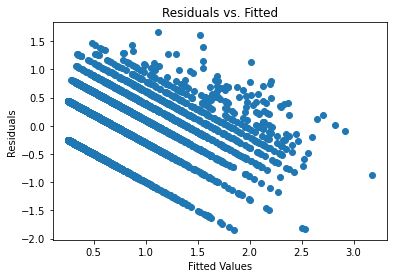

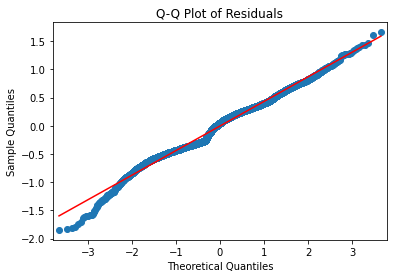

In [64]:
residuals = model.resid_response
fitted_values = model.fittedvalues
plt.scatter(fitted_values, residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted')
plt.show()

# Quantile-Quantile plot of the residuals
sm.qqplot(residuals, line='s')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.title('Q-Q Plot of Residuals')
plt.show()

## Layering on IMD

In [65]:
imd_data = pd.read_csv('../data/Index_of_Multiple_Deprivation_(Dec_2019)_Lookup_in_England.csv')
imd_data.head()

,FID,LSOA11CD,LSOA11NM,LAD19CD,LAD19NM,IMD19
0,1,E01000001,City of London 001A,E09000001,City of London,29199
1,2,E01000104,Barking and Dagenham 014B,E09000002,Barking and Dagenham,6002
2,3,E01000205,Barnet 035A,E09000003,Barnet,27397
3,4,E01000002,City of London 001B,E09000001,City of London,30379
4,5,E01000003,City of London 001C,E09000001,City of London,14915


In [66]:
oa11_lsoa11_lookup = pd.read_csv('../data/Output_Area_to_Lower_layer_Super_Output_Area_to_Middle_layer_Super_Output_Area_to_Local_Authority_District_(December_2011)_Lookup_in_England_and_Wales.csv')
oa11_lsoa11_lookup.head()


/var/folders/zs/1hvc18dn7v94z77k1xy7g90c0000gn/T/ipykernel_92944/1005487974.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  oa11_lsoa11_lookup = pd.read_csv('data/Output_Area_to_Lower_layer_Super_Output_Area_to_Middle_layer_Super_Output_Area_to_Local_Authority_District_(December_2011)_Lookup_in_England_and_Wales.csv')


,OA11CD,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,LAD11NMW,ObjectId
0,E00000001,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,NaN,1
1,E00000003,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,NaN,2
2,E00000005,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,NaN,3
3,E00000007,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,NaN,4
4,E00000010,E01000003,City of London 001C,E02000001,City of London 001,E09000001,City of London,NaN,5


In [67]:
oa11_oa21_lookup.head()

,ObjectId,OA11CD,OA21CD,CHNGIND,LAD22CD,LAD22NM,LAD22NMW
0,1,E00000124,E00000124,U,E09000002,Barking and Dagenham,NaN
1,2,E00000125,E00000125,U,E09000002,Barking and Dagenham,NaN
2,3,E00000128,E00000128,U,E09000002,Barking and Dagenham,NaN
3,4,E00000129,E00000129,U,E09000002,Barking and Dagenham,NaN
4,5,E00000130,E00000130,U,E09000002,Barking and Dagenham,NaN


In [68]:
imd_frame = oa11_oa21_lookup[['OA11CD', 'OA21CD']].merge(
    oa11_lsoa11_lookup[['OA11CD', 'LSOA11CD']], how='inner', on='OA11CD'
).merge(
    imd_data[['LSOA11CD', 'IMD19']],
    how='inner',
    on='LSOA11CD'
)

imd_frame.head()

,OA11CD,OA21CD,LSOA11CD,IMD19
0,E00000124,E00000124,E01000022,6098
1,E00000116,E00000116,E01000022,6098
2,E00000120,E00000120,E01000022,6098
3,E00000122,E00000122,E01000022,6098
4,E00000125,E00000125,E01000023,5243


In [69]:
oa_total_frame.head()

,OA21CD,PAR22CD,PAR22NM,RGN22NM,population,area,amenities
0,E00060311,E04000255,Dalton Piercy,North East,312,6.758443e+06,"[{'name': 'N/A', 'amenity': 'post_box', 'data_..."
1,E00060356,E04000257,Greatham,North East,283,5.098650e+05,"[{'name': 'The Bull and Dog', 'amenity': 'pub'..."
2,E00060360,E04000257,Greatham,North East,274,6.863565e+04,[]
3,E00060357,E04000257,Greatham,North East,298,3.589880e+05,"[{'name': 'N/A', 'amenity': 'waste_basket', 'd..."
4,E00060359,E04000257,Greatham,North East,274,6.126857e+04,[]


In [70]:
imd_frame.groupby(['OA21CD']).size().sort_values(ascending=False).head(10)

OA21CD
E00182748    5
E00189918    5
E00178635    4
E00180779    4
E00189204    4
E00178724    4
E00181936    4
E00185187    4
E00189219    4
E00176912    3
dtype: int64

In [71]:
raw_oa21_imd_lookup = imd_frame[['OA21CD', 'IMD19']].drop_duplicates()
oa_total_frame = oa_total_frame.merge(raw_oa21_imd_lookup, how='left', on='OA21CD')
oa_total_frame.head()

,OA21CD,PAR22CD,PAR22NM,RGN22NM,population,area,amenities,IMD19
0,E00060311,E04000255,Dalton Piercy,North East,312,6.758443e+06,"[{'name': 'N/A', 'amenity': 'post_box', 'data_...",22123.0
1,E00060356,E04000257,Greatham,North East,283,5.098650e+05,"[{'name': 'The Bull and Dog', 'amenity': 'pub'...",14530.0
2,E00060360,E04000257,Greatham,North East,274,6.863565e+04,[],14530.0
3,E00060357,E04000257,Greatham,North East,298,3.589880e+05,"[{'name': 'N/A', 'amenity': 'waste_basket', 'd...",14530.0
4,E00060359,E04000257,Greatham,North East,274,6.126857e+04,[],14530.0


In [72]:
parish_data.head()

,PAR22CD,PAR22NM,RGN22NM,population,area,amenity_list,rural_label,pub,school,place_of_worship
0,E04000001,Blackrod,North West,5517,8.599134e+06,"{'post_box': 3, 'place_of_worship': 2, 'fast_f...",Urban,5,2,2
1,E04000002,Horwich,North West,20908,1.424275e+07,"{'waste_basket': 6, 'parking': 48, 'school': 9...",Mixed,14,9,8
2,E04000003,Westhoughton,North West,25340,1.786415e+07,"{'waste_basket': 22, 'charging_station': 1, 'a...",Mixed,10,9,9
3,E04000005,Saddleworth,North West,25466,7.613353e+07,"{'parking': 115, 'telephone': 8, 'bench': 63, ...",Mixed,34,14,16
4,E04000008,Mossley,North West,11566,8.658747e+06,"{'place_of_worship': 5, 'parking': 16, 'waste_...",Mixed,11,6,5


In [73]:
def weighted_imd(x,weighting_column):
    imd_total = 0
    weighting_total = 0
    for row in x.iterrows():
        imd_total += row[1].IMD19 * row[1][weighting_column]
        weighting_total += row[1][weighting_column]
    total = imd_total/weighting_total
    return total

parish_imd_frame = oa_total_frame.groupby(['PAR22CD', 'PAR22NM']).apply(lambda x: weighted_imd(x, 'population')).reset_index()
parish_imd_frame.columns = ['PAR22CD', 'PAR22NM', 'population_weighted_imd']
parish_imd_frame.head()


,PAR22CD,PAR22NM,population_weighted_imd
0,E04000001,Blackrod,20311.266630
1,E04000002,Horwich,14657.016644
2,E04000003,Westhoughton,18738.612747
3,E04000005,Saddleworth,25033.770282
4,E04000008,Mossley,14241.922013


In [74]:
inty = oa_total_frame.groupby(['PAR22CD', 'PAR22NM']).apply(lambda x: weighted_imd(x, 'area')).reset_index()
inty.columns = ['PAR22CD', 'PAR22NM', 'area_weighted_imd']
inty.head()

,PAR22CD,PAR22NM,area_weighted_imd
0,E04000001,Blackrod,23220.071314
1,E04000002,Horwich,22628.188830
2,E04000003,Westhoughton,18446.579204
3,E04000005,Saddleworth,24561.313884
4,E04000008,Mossley,9925.190128


In [75]:
parish_imd_frame = parish_imd_frame.merge(inty, how='inner', on=['PAR22CD', 'PAR22NM'])
parish_imd_frame.head()

,PAR22CD,PAR22NM,population_weighted_imd,area_weighted_imd
0,E04000001,Blackrod,20311.266630,23220.071314
1,E04000002,Horwich,14657.016644,22628.188830
2,E04000003,Westhoughton,18738.612747,18446.579204
3,E04000005,Saddleworth,25033.770282,24561.313884
4,E04000008,Mossley,14241.922013,9925.190128


In [76]:
parish_imd_frame[pd.isnull(parish_imd_frame.area_weighted_imd)].head()

,PAR22CD,PAR22NM,population_weighted_imd,area_weighted_imd
9575,W04000001,Aberffraw,NaN,NaN
9576,W04000002,Amlwch,NaN,NaN
9577,W04000003,Beaumaris,NaN,NaN
9578,W04000004,Bodedern,NaN,NaN
9579,W04000005,Bodffordd,NaN,NaN


In [77]:
parish_data = parish_data.merge(
    parish_imd_frame[['PAR22CD', 'population_weighted_imd', 'area_weighted_imd']],
    how='inner',
    on='PAR22CD'
)

parish_data.head()

,PAR22CD,PAR22NM,RGN22NM,population,area,amenity_list,rural_label,pub,school,place_of_worship,population_weighted_imd,area_weighted_imd
0,E04000001,Blackrod,North West,5517,8.599134e+06,"{'post_box': 3, 'place_of_worship': 2, 'fast_f...",Urban,5,2,2,20311.266630,23220.071314
1,E04000002,Horwich,North West,20908,1.424275e+07,"{'waste_basket': 6, 'parking': 48, 'school': 9...",Mixed,14,9,8,14657.016644,22628.188830
2,E04000003,Westhoughton,North West,25340,1.786415e+07,"{'waste_basket': 22, 'charging_station': 1, 'a...",Mixed,10,9,9,18738.612747,18446.579204
3,E04000005,Saddleworth,North West,25466,7.613353e+07,"{'parking': 115, 'telephone': 8, 'bench': 63, ...",Mixed,34,14,16,25033.770282,24561.313884
4,E04000008,Mossley,North West,11566,8.658747e+06,"{'place_of_worship': 5, 'parking': 16, 'waste_...",Mixed,11,6,5,14241.922013,9925.190128


In [78]:
parish_data[parish_data.PAR22NM == 'Great Ouseburn']

,PAR22CD,PAR22NM,RGN22NM,population,area,amenity_list,rural_label,pub,school,place_of_worship,population_weighted_imd,area_weighted_imd
5082,E04007350,Great Ouseburn,Yorkshire and The Humber,623,8.649654e+06,"{'post_box': 2, 'post_office': 1, 'school': 1,...",Rural,1,1,1,23792.0,23792.0


## Powerlaw time

In [79]:
fit = powerlaw.Fit(parish_data.pub.values, discrete=True)

Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values


In [80]:
fit.power_law.alpha

1.9883371818205953

In [81]:
fit.power_law.sigma

0.03354634982184953

In [82]:
fit.distribution_compare('power_law', 'exponential')

(301.02365425419674, 1.4951485876409844e-19)

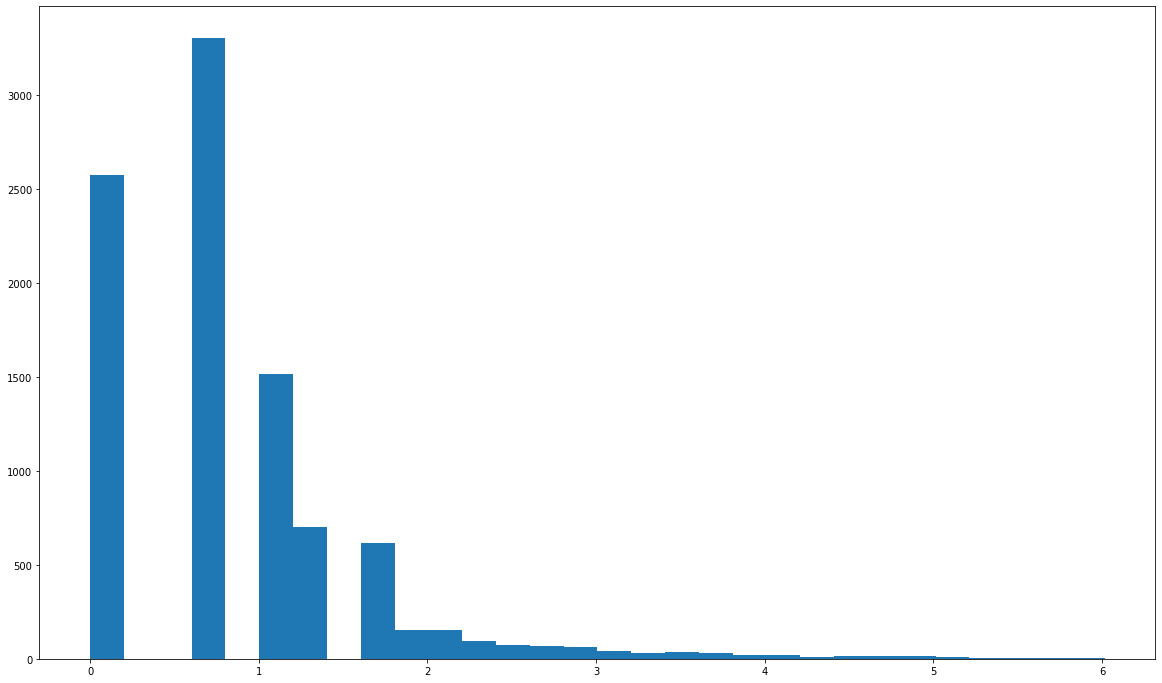

In [83]:
fig, ax = plt.subplots(figsize=(20,12))

plt.hist(np.log(parish_data.pub.values + 1), bins=30)
plt.show()

In [84]:
len(parish_data.pub.values)

9575

In [85]:
np.max(parish_data.pub.values)

409

In [86]:
from collections import Counter
Counter(parish_data.pub.values).most_common(10)

[(1, 3306),
 (0, 2574),
 (2, 1514),
 (3, 699),
 (4, 392),
 (5, 222),
 (6, 151),
 (7, 91),
 (8, 64),
 (10, 47)]

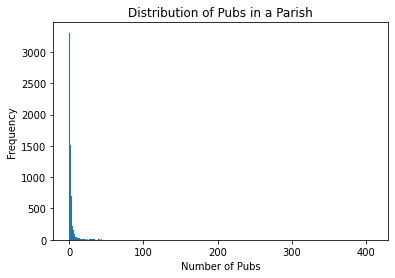

In [87]:
data = parish_data.pub.values
plt.hist(data, bins=range(max(data)+2), align='left')
plt.xlabel('Number of Pubs')
plt.ylabel('Frequency')
plt.title('Distribution of Pubs in a Parish')
plt.show()

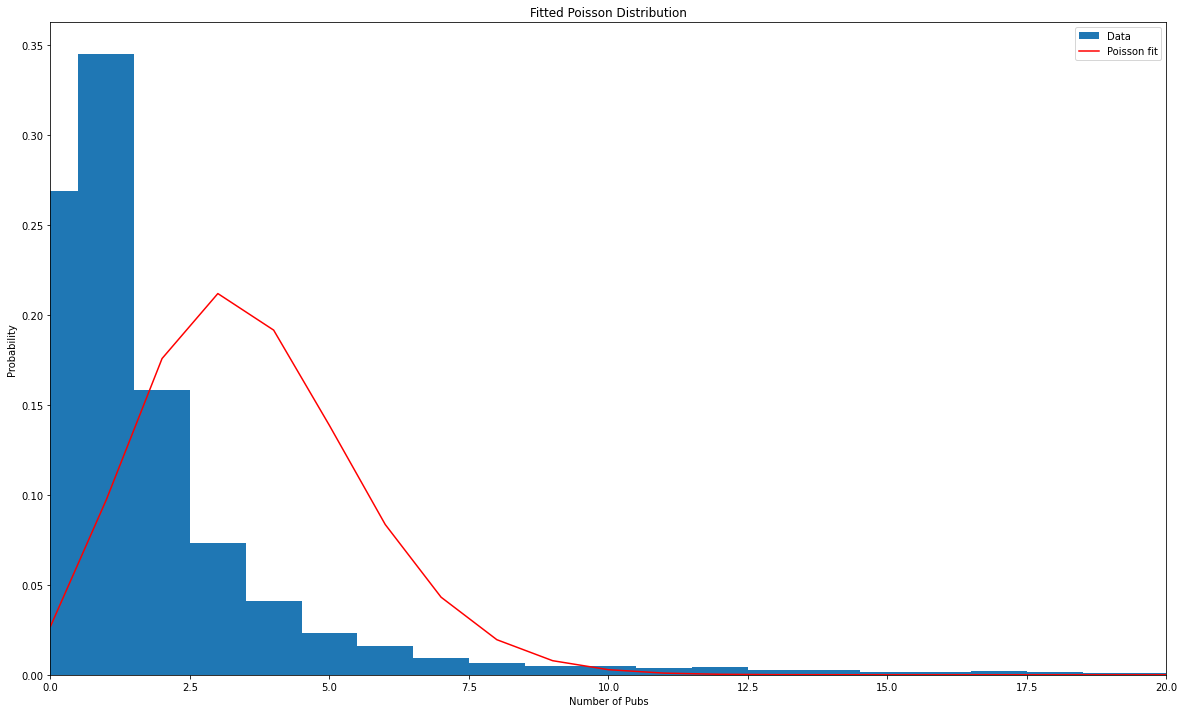

In [88]:
from scipy.stats import poisson
mu = np.mean(data)

x = np.arange(0, max(data) + 1)
dist = poisson.pmf(x, mu)
fig, ax = plt.subplots(figsize=(20,12))
plt.hist(data, bins=range(max(data) + 2), align='left', density=True, label='Data')
plt.plot(x, dist, 'r-', label='Poisson fit')
plt.xlabel('Number of Pubs')
plt.ylabel('Probability')
plt.title('Fitted Poisson Distribution')
plt.xlim([0,20])
plt.legend()
plt.show()

In [89]:
mu

3.6165013054830286

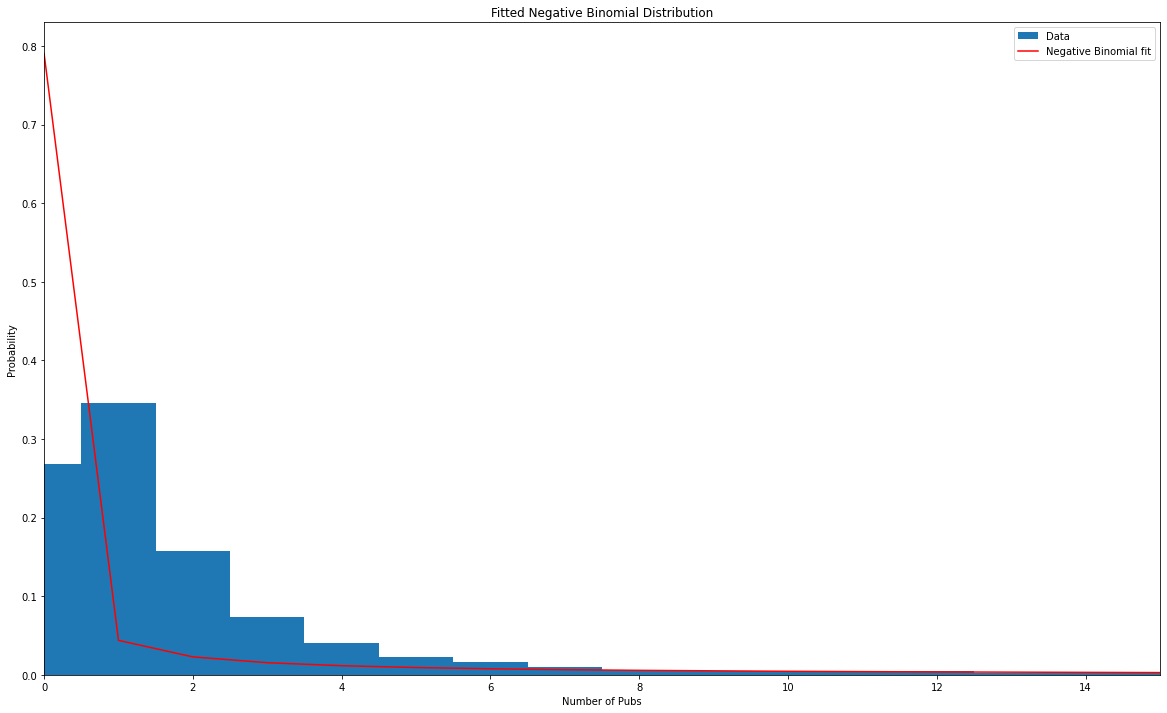

In [90]:
from scipy.stats import nbinom

fig, ax = plt.subplots(figsize=(20,12))
# Plot the fitted Negative Binomial distribution
x = np.arange(0, max(data) + 1)
plt.hist(data, bins=range(max(data) + 2), align='left', density=True, label='Data')
plt.plot(x, nbinom.pmf(x, 0.056287, 0.01532555), 'r-', label='Negative Binomial fit')
plt.xlabel('Number of Pubs')
plt.ylabel('Probability')
plt.title('Fitted Negative Binomial Distribution')
plt.xlim([0,15])
plt.legend()
plt.show()

In [91]:
from scipy.special import gammaln, factorial
from scipy.special import psi
from scipy.optimize import fmin_l_bfgs_b as optim

def fit_nbinom(X, initial_params=None):
    infinitesimal = np.finfo(np.float).eps

    def log_likelihood(params, *args):
        r, p = params
        X = args[0]
        N = X.size

        #MLE estimate based on the formula on Wikipedia:
        # http://en.wikipedia.org/wiki/Negative_binomial_distribution#Maximum_likelihood_estimation
        result = np.sum(gammaln(X + r)) \
            - np.sum(np.log(factorial(X))) \
            - N*(gammaln(r)) \
            + N*r*np.log(p) \
            + np.sum(X*np.log(1-(p if p < 1 else 1-infinitesimal)))

        return -result

    def log_likelihood_deriv(params, *args):
        r, p = params
        X = args[0]
        N = X.size

        pderiv = (N*r)/p - np.sum(X)/(1-(p if p < 1 else 1-infinitesimal))
        rderiv = np.sum(psi(X + r)) \
            - N*psi(r) \
            + N*np.log(p)

        return np.array([-rderiv, -pderiv])

    if initial_params is None:
        #reasonable initial values (from fitdistr function in R)
        m = np.mean(X)
        v = np.var(X)
        size = (m**2)/(v-m) if v > m else 10

        #convert mu/size parameterization to prob/size
        p0 = size / ((size+m) if size+m != 0 else 1)
        r0 = size
        initial_params = np.array([r0, p0])

    bounds = [(infinitesimal, None), (infinitesimal, 1)]
    optimres = optim(log_likelihood,
                     x0=initial_params,
                     #fprime=log_likelihood_deriv,
                     args=(X,),
                     approx_grad=1,
                     bounds=bounds)

    params = optimres[0]
    return {'size': params[0], 'prob': params[1]}

In [92]:
fit_nbinom(data)

/var/folders/zs/1hvc18dn7v94z77k1xy7g90c0000gn/T/ipykernel_92944/2323368068.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  infinitesimal = np.finfo(np.float).eps
/opt/homebrew/lib/python3.9/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


{'size': 0.05628753321296469, 'prob': 0.01532555659610132}

In [93]:
nbinom.pmf(x, 0.01532555, 0.056287)

array([9.56862020e-01, 1.38390196e-02, 6.63010767e-03, 4.20324277e-03,
       2.99018893e-03, 2.26615350e-03, 1.78762797e-03, 1.44970012e-03,
       1.19970910e-03, 1.00831110e-03, 8.57858978e-04, 7.37103077e-04,
       6.38534331e-04, 5.56950220e-04, 4.88633589e-04, 4.30859017e-04,
       3.81583770e-04, 3.39247520e-04, 3.02638640e-04, 2.70802599e-04,
       2.42977766e-04, 2.18549510e-04, 1.97016779e-04, 1.77967389e-04,
       1.61059463e-04, 1.46007328e-04, 1.32570655e-04, 1.20546010e-04,
       1.09760216e-04, 1.00065085e-04, 9.13332049e-05, 8.34545461e-05,
       7.63336981e-05, 6.98876155e-05, 6.40437609e-05, 5.87385677e-05,
       5.39161606e-05, 4.95272844e-05, 4.55284045e-05, 4.18809453e-05,
       3.85506457e-05, 3.55070092e-05, 3.27228335e-05, 3.01738077e-05,
       2.78381642e-05, 2.56963794e-05, 2.37309124e-05, 2.19259801e-05,
       2.02673591e-05, 1.87422143e-05, 1.73389472e-05, 1.60470640e-05,
       1.48570588e-05, 1.37603104e-05, 1.27489918e-05, 1.18159892e-05,
      

In [94]:
from scipy.stats._continuous_distns import _distn_names

In [95]:
rural_only = parish_data[parish_data.rural_label == 'Rural']
rural_only.shape

(7781, 12)

In [96]:
rural_only.head()

,PAR22CD,PAR22NM,RGN22NM,population,area,amenity_list,rural_label,pub,school,place_of_worship,population_weighted_imd,area_weighted_imd
6,E04000010,Dunham Massey,North West,470,9.550626e+06,"{'parking': 12, 'pub': 3, 'telephone': 1, 'pos...",Rural,3,0,1,22793.000000,22793.000000
8,E04000012,Warburton,North West,342,7.960080e+06,"{'post_box': 2, 'parking': 1, 'grave_yard': 2,...",Rural,1,0,1,22793.000000,22793.000000
17,E04000022,Billinge Chapel End,North West,5827,7.349949e+06,"{'school': 4, 'pub': 6, 'parking': 14, 'librar...",Rural,6,4,2,20278.382186,18905.542543
24,E04000030,Ince Blundell,North West,462,9.309675e+06,"{'community_centre': 1, 'place_of_worship': 1,...",Rural,0,0,1,16806.000000,16806.000000
31,E04000037,Hightown,North West,2018,3.095659e+06,"{'place_of_worship': 1, 'bench': 1, 'post_box'...",Rural,0,0,1,26895.000000,26895.000000


  1 / 19 : binom
About to append
  2 / 19 : bernoulli
About to append
  3 / 19 : betabinom
About to append
  4 / 19 : nbinom
About to append
  5 / 19 : geom
About to append
  6 / 19 : hypergeom
About to append
  7 / 19 : nhypergeom
  8 / 19 : logser
About to append
  9 / 19 : poisson
About to append
 10 / 19 : planck
About to append
 11 / 19 : boltzmann
About to append
 12 / 19 : randint
 13 / 19 : zipf
About to append
 14 / 19 : zipfian
About to append
 15 / 19 : dlaplace
About to append
 16 / 19 : skellam
About to append
 17 / 19 : yulesimon
About to append
 18 / 19 : nchypergeom_fisher
 19 / 19 : nchypergeom_wallenius


Text(0, 0.5, 'Frequency')

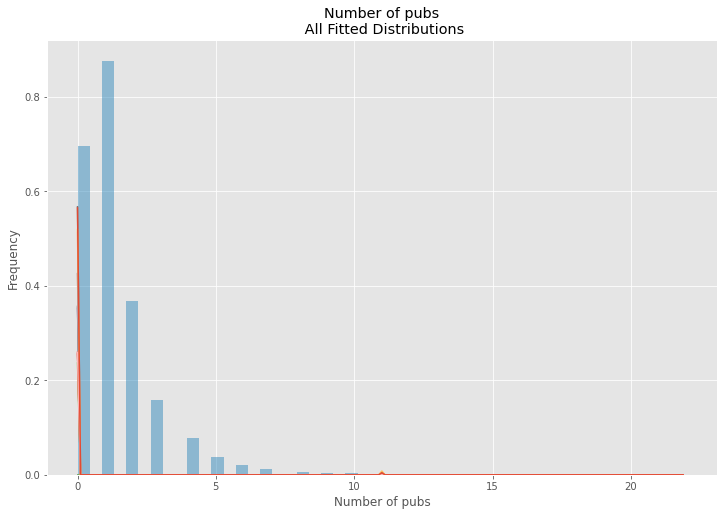

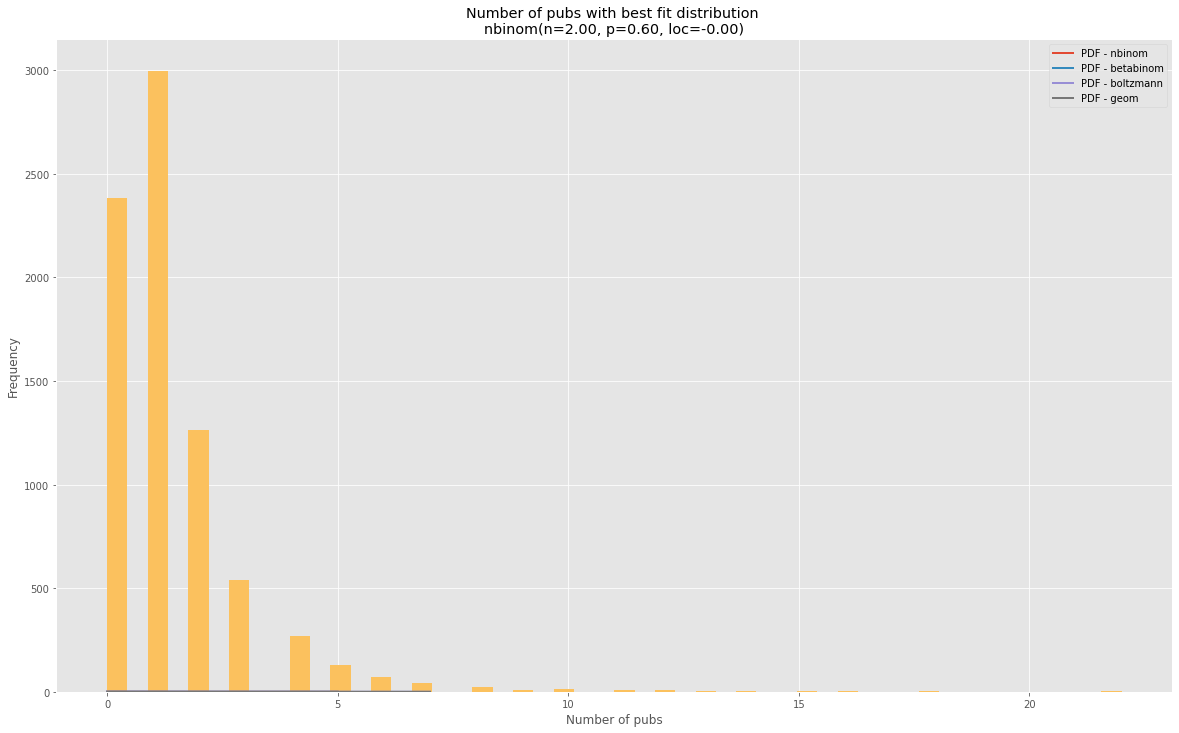

In [97]:
import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
from scipy.stats._discrete_distns import _distn_names
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import fit

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = x[:-1]

    # Best holders
    best_distributions = []

    # Estimate distribution parameters from data
    for ii, distribution in enumerate([d for d in _distn_names if not d in ['levy_stable', 'studentized_range']]):

        print("{:>3} / {:<3}: {}".format( ii+1, len(_distn_names), distribution ))

        distribution = getattr(st, distribution)

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = fit(distribution, data, bounds = {
                    'n': [-1000,1000], 
                    'p': [-1000, 1000], 
                    'mu': [-1000,1000], 
                    'scale': [-1000, 1000],
                    'loc': [-1000,1000],
                    'a': [-1000, 1000],
                    'lambda_': [-1000,1000],
                    'lambda': [-1000,1000],
                    'N': [-1000, 1000],
                    'b': [-1000,1000],
                    'M': [-1000,1000],
                    'mu1': [-1000,1000],
                    'mu2': [-1000,1000],
                    'alpha': [-1000,1000],
#                    'odds': [-10,20]
                })
                score = params.nllf()

                # Separate parts of parameters
                better_params = params.params

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pmf(x,*better_params)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        ax.plot(x, pdf)
#                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                print("About to append")
                best_distributions.append((distribution, better_params, score))
        except Exception:
            pass
            

    
    return sorted(best_distributions, key=lambda x:x[2])

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters


    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *params) 
    end = dist.ppf(0.99, *params)

    # Build PDF and turn into pandas Series
    x = np.arange(start, end)
    y = dist.pmf(x, *params)
    pdf = pd.Series(y, x)

    return pdf

# Load data from statsmodels datasets
data = pd.Series(parish_data[parish_data.rural_label == 'Rural'].pub.values)

# Plot for comparison
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, density=True, alpha=0.5, color=list(matplotlib.rcParams['axes.prop_cycle'])[1]['color'])

# Save plot limits
dataYLim = ax.get_ylim()

# Find best fit distribution
best_distibutions = best_fit_distribution(data, 200, ax)
best_dist = best_distibutions[0]

# Update plots
ax.set_ylim(dataYLim)
ax.set_title(u'Number of pubs\n All Fitted Distributions')
ax.set_xlabel(u'Number of pubs')
ax.set_ylabel('Frequency')

# Make PDF with best params 
plt.figure(figsize=(20,12))
for i in range(4):
    disty = best_distibutions[i]
    pdf = make_pdf(disty[0], disty[1])
    ax = pdf.plot(lw=2, label='PDF - {0}'.format(disty[0].name), legend=True)
# Display

ax.hist(data, bins=50, label='Data')

#data.plot(kind='hist', bins=50, density=True, alpha=0.5, label='Data', legend=True, ax=ax)

param_names = (best_dist[0].shapes + ', loc, scale').split(', ') if best_dist[0].shapes else ['loc', 'scale']
param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_dist[1])])
dist_str = '{}({})'.format(best_dist[0].name, param_str)

ax.set_title(u'Number of pubs with best fit distribution \n' + dist_str)
ax.set_xlabel(u'Number of pubs')
ax.set_ylabel('Frequency')

In [98]:
np.sum(make_pdf(best_distibutions[0][0], best_distibutions[0][1]))

0.9803227238241499

In [99]:
best_distibutions

[(<scipy.stats._discrete_distns.nbinom_gen at 0x16863a520>,
  FitParams(n=2.0, p=0.5968168798779716, loc=-0.0),
  12269.337912205116),
 (<scipy.stats._discrete_distns.betabinom_gen at 0x168636790>,
  FitParams(n=630.0, a=2.0904238638470543, b=972.8333120636117, loc=0.0),
  12270.915869088358),
 (<scipy.stats._discrete_distns.boltzmann_gen at 0x16863a430>,
  FitParams(lambda_=0.5539605534988499, N=834.0, loc=-0.0),
  12475.67291797913),
 (<scipy.stats._discrete_distns.geom_gen at 0x168636eb0>,
  FitParams(p=0.42561162373847367, loc=-1.0),
  12475.675870763718),
 (<scipy.stats._discrete_distns.poisson_gen at 0x168636700>,
  FitParams(mu=1.3511116823150262, loc=0.0),
  12993.30531680685),
 (<scipy.stats._discrete_distns.skellam_gen at 0x1686406a0>,
  FitParams(mu1=1.3511118084679905, mu2=1.1953190036306928e-09, loc=-0.0),
  12993.305318780935),
 (<scipy.stats._discrete_distns.binom_gen at 0x16860fee0>,
  FitParams(n=71.0, p=0.019029737323113437, loc=-0.0),
  13079.351911412694),
 (<scipy.

In [101]:
from scipy import stats
alternative = stats.betabinom.rvs(n=450, a=2.10153167667377, b=698.4475720315137, size=300)
stats.kstest(data.values, alternative)

KstestResult(statistic=0.07501820674292078, pvalue=0.0734245806690831, statistic_location=1, statistic_sign=1)

In [102]:
np.max(data)

22

### Let's model it

In [103]:
parish_data.head()

,PAR22CD,PAR22NM,RGN22NM,population,area,amenity_list,rural_label,pub,school,place_of_worship,population_weighted_imd,area_weighted_imd
0,E04000001,Blackrod,North West,5517,8.599134e+06,"{'post_box': 3, 'place_of_worship': 2, 'fast_f...",Urban,5,2,2,20311.266630,23220.071314
1,E04000002,Horwich,North West,20908,1.424275e+07,"{'waste_basket': 6, 'parking': 48, 'school': 9...",Mixed,14,9,8,14657.016644,22628.188830
2,E04000003,Westhoughton,North West,25340,1.786415e+07,"{'waste_basket': 22, 'charging_station': 1, 'a...",Mixed,10,9,9,18738.612747,18446.579204
3,E04000005,Saddleworth,North West,25466,7.613353e+07,"{'parking': 115, 'telephone': 8, 'bench': 63, ...",Mixed,34,14,16,25033.770282,24561.313884
4,E04000008,Mossley,North West,11566,8.658747e+06,"{'place_of_worship': 5, 'parking': 16, 'waste_...",Mixed,11,6,5,14241.922013,9925.190128
